In [8]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [9]:
import matplotlib.pyplot as plt
import math
import numpy as np
from tqdm import tqdm 
import multiprocessing as mp
from multiprocessing import Pool
import os

In [10]:
import mc_lib

In [11]:
print(mc_lib.get_include())

/home/ddsukhoverkhova/.conda/envs/mc_lib_env/lib/python3.7/site-packages/mc_lib


In [12]:
%%cython -a -I</home/ddsukhoverkhova/.conda/envs/mc_lib_env/lib/python3.7/site-packages/mc_lib>
from mc_lib.rndm cimport RndmWrapper
cdef RndmWrapper rndm = RndmWrapper((123, 0))
print(rndm.uniform())

/home/ddsukhoverkhova/.cache/ipython/cython/_cython_magic_7be88af85aa9436ff04a7c3ab0f80e31.c:698:31: fatal error: numpy/arrayobject.h: No such file or directory
 #include "numpy/arrayobject.h"
                               ^
compilation terminated.


In [18]:
%%cython -a --cplus --compile-args=-std=c++11 -I</home/ddsukhoverkhova/.conda/envs/mc_lib_env/lib/python3.7/site-packages/mc_lib>
cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from mc_lib.lattices import tabulate_neighbors
from mc_lib.observable cimport RealObservable

cdef RndmWrapper rndm = RndmWrapper((1234, 0)) # global variable
    
cdef void init_spins(signed char[::1] spins): 
    
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1  
        
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(signed char[::1] spins, 
                   long[:, ::1] neighbors,
                  const double[:,::1] Js):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * Js[site, site1] * spins[site] * spins[site1] 
    
    return ene / 2.0



@cython.boundscheck(False)
@cython.wraparound(False)
cdef void flip_spin(signed char[::1] spins, 
                    const long[:, ::1] neighbors,
                    double beta,
                    const double[:,::1] Js): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef int num_neighb = neighbors[site, 0]
    cdef double summ = 0.
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        summ += spins[site1] * spins[site] * Js[site,site1]
   
    cdef double ratio = exp(-2.0 * beta * summ )
    
    if rndm.uniform() > ratio:
        return

    spins[site] = -spins[site]
    
    
cdef void get_J( double[:,::1] Js, double J, double Jd, int L1, int L2 , int L3 = 1):
  
    if L3 == 1:
        for i in range(L1*L2):
            Js[i, ((i // L2 + 1) % L1 * L2 )  + (i + 1) % L2 ] = Jd
            Js[i, ((i // L2  - 1) % L1 * L2 )  + (i - 1) % L2 ] = Jd
            Js[i, (i // L2) * L2 + (i + 1) % L2] = J 
            Js[i, (i + L2) % (L1*L2)] = J
            Js[i, (i // L2) * L2 + (i - 1) % L2] = J
            Js[i, (i - L2) % (L1*L2)] = J
        return
    
    else:
        return
    
def det_energies(double J, double Jd): # возвращает энергии для всех возможных конфигураций системы 4х4
    
    cdef int L = 4
    
    cdef long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang')
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)
    
    A = [-1,1]
    conf = [(a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16) for a1 in A for a2 in A for a3 in A for a4 in A for a5 in A for a6 in A for a7 in A for a8 in A for a9 in A for a10 in A for a11 in A for a12 in A for a13 in A for a14 in A for a15 in A for a16 in A]
    cdef signed char[:,::1] configs = np.asarray(conf) # перебор всех конфигураций
    
    energies = []
    magns = []
    cdef int i
    for i in range(2**16):
        energies.append(energy(configs[i], neighbors, Js))
        magns.append((np.sum(configs[i]))**2)
        
    return (np.asarray(energies),np.asarray( magns))
        

def simulate(Py_ssize_t L,
             double T, double J, double Jd,
             Py_ssize_t num_sweeps,
             Py_ssize_t num_conf):

    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang') 
        double beta = 1./T

    cdef:
        int num_therm = int(20*L**2.15)
        int steps_per_sweep = int(L * L)
        int step = 0, sweep = 0
        int i
        # double av_en = 0., Z = 0., magn = 0., av_magn=0.

    cdef signed char[::1] spins =  np.empty( L*L, dtype=np.int8) 
    init_spins(spins)
    
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    cdef signed char[:,::1] res = np.empty((num_conf, L*L), dtype=np.int8)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            step += 1
            flip_spin(spins, neighbors, beta, Js)

    for conf in range(num_conf):
        for sweep in range(num_sweeps):
            for i in range(steps_per_sweep):
                step += 1
                flip_spin(spins, neighbors, beta, Js)
                
        res[conf, :] = spins
    
    return (res)


Error compiling Cython file:
------------------------------------------------------------
...
    
cdef void init_spins(signed char[::1] spins): 
    
    for j in range(spins.shape[0]):
        #spins[j] = 1 if rndm.uniform() > 0.5 else -1
        if (rndm.uniform() > 0.5){
                                ^
------------------------------------------------------------

/home/ddsukhoverkhova/.cache/ipython/cython/_cython_magic_2ea92561410a80a03b08b5d4c82ed0d4.pyx:16:33: Expected ':', found '{'


In [7]:
with open('binder_4.npy', 'rb') as f:
    binder_4 = np.load(f)
with open('binder_10.npy', 'rb') as f:
    binder_10 = np.load(f)
with open('binder_20.npy', 'rb') as f:
    binder_20 = np.load(f)
#with open('/content/drive/MyDrive/ВКР/binder_40.npy', 'rb') as f:
#    binder_40 = np.load(f)

with open('err_4.npy', 'rb') as f:
    err_4 = np.load(f)
with open('err_10.npy', 'rb') as f:
    err_10 = np.load(f)
with open('err_20.npy', 'rb') as f:
    err_20 = np.load(f)
#with open('/content/drive/MyDrive/ВКР/err_40.npy', 'rb') as f:
#    err_40 = np.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'binder_4.npy'

In [8]:
num_temps = 25
T = np.linspace(0.5, 3, num_temps)
L = [10, 20, 40, 80]
# 0 - Jd, num_temps - temperatures, len(L) - lattice sizes
binder = np.zeros((3, num_temps, len(L)))  
err = np.zeros((3, num_temps, len(L)))
num_sweeps = 2000000

In [10]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  48


In [23]:
data = [L[i],T[j],1,0,num_sweeps]
print(data[0], data[1], data[2], data[3], data[4])

10 0.5 1 0 2000000


In [ ]:
# L = 4
#for i in range(len(L)):
i = 0
for j in tqdm(range(num_temps)):
    sml = simulate(L[i],T[j],1,0,num_sweeps)
    sml_01 = simulate(L[i],T[j],1,-0.1,num_sweeps)
    sml_05 = simulate(L[i],T[j],1,-0.5,num_sweeps)

    binder[0, j, i] += sml[0]
    binder[1, j, i] += sml_01[0]
    binder[2, j, i] += sml_05[0]

    err[0, j, i] += sml[1]
    err[1, j, i] += sml_01[1]
    err[2, j, i] += sml_05[1]

In [9]:
# L = 4
#for i in range(len(L)):
i = 0
for j in tqdm(range(num_temps)):
    sml = simulate(L[i],T[j],1,0,num_sweeps)
    sml_01 = simulate(L[i],T[j],1,-0.1,num_sweeps)
    sml_05 = simulate(L[i],T[j],1,-0.5,num_sweeps)

    binder[0, j, i] += sml[0]
    binder[1, j, i] += sml_01[0]
    binder[2, j, i] += sml_05[0]

    err[0, j, i] += sml[1]
    err[1, j, i] += sml_01[1]
    err[2, j, i] += sml_05[1]

100%|██████████| 50/50 [05:46<00:00,  6.93s/it]


In [10]:
# L = 10
#for i in range(len(L)):
i = 1
for j in tqdm(range(num_temps)):
    sml = simulate(L[i],T[j],1,0,num_sweeps)
    sml_01 = simulate(L[i],T[j],1,-0.1,num_sweeps)
    sml_05 = simulate(L[i],T[j],1,-0.5,num_sweeps)

    binder[0, j, i] += sml[0]
    binder[1, j, i] += sml_01[0]
    binder[2, j, i] += sml_05[0]

    err[0, j, i] += sml[1]
    err[1, j, i] += sml_01[1]
    err[2, j, i] += sml_05[1]

100%|██████████| 50/50 [34:03<00:00, 40.88s/it]


In [11]:
# L = 20
#for i in range(len(L)):
i = 2
for j in tqdm(range(num_temps)):
    sml = simulate(L[i],T[j],1,0,num_sweeps)
    sml_01 = simulate(L[i],T[j],1,-0.1,num_sweeps)
    sml_05 = simulate(L[i],T[j],1,-0.5,num_sweeps)

    binder[0, j, i] += sml[0]
    binder[1, j, i] += sml_01[0]
    binder[2, j, i] += sml_05[0]

    err[0, j, i] += sml[1]
    err[1, j, i] += sml_01[1]
    err[2, j, i] += sml_05[1]

100%|██████████| 50/50 [2:17:03<00:00, 164.47s/it]  


In [12]:
# L = 40
#for i in range(len(L)):
i = 3
for j in tqdm(range(num_temps)):
    sml = simulate(L[i],T[j],1,0,num_sweeps)
    sml_01 = simulate(L[i],T[j],1,-0.1,num_sweeps)
    sml_05 = simulate(L[i],T[j],1,-0.5,num_sweeps)

    binder[0, j, i] += sml[0]
    binder[1, j, i] += sml_01[0]
    binder[2, j, i] += sml_05[0]

    err[0, j, i] += sml[1]
    err[1, j, i] += sml_01[1]
    err[2, j, i] += sml_05[1]

100%|██████████| 50/50 [9:34:42<00:00, 689.65s/it]  


In [ ]:
with open('data_binders/binder_4.npy', 'wb') as f:
    np.save(f, binder[:, :, 0])
with open('data_binders/err_4.npy', 'wb') as f:
    np.save(f, err[:, :, 0])

In [ ]:
with open('data_binders/binder_10.npy', 'wb') as f:
    np.save(f, binder[:, :, 1])    
with open('data_binders/err_10.npy', 'wb') as f:
    np.save(f, err[:, :, 1])

In [ ]:
with open('data_binders/binder_20.npy', 'wb') as f:
    np.save(f, binder[:, :, 2])
with open('data_binders/err_20.npy', 'wb') as f:
    np.save(f, err[:, :, 2])

In [ ]:
with open('data_binders/binder_40.npy', 'wb') as f:
    np.save(f, binder[:, :, 3])    
with open('data_binders/err_40.npy', 'wb') as f:
    np.save(f, err[:, :, 3])

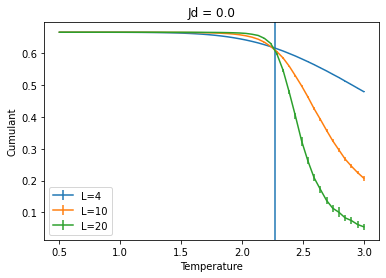

In [9]:
#Jd = 0.0
plt.errorbar(T, binder_4[0, :], err_4[0, :], label = "L=4")#, fmt='o-')
plt.errorbar(T, binder_10[0, :], err_10[0, :], label = "L=10")#, fmt='o-')
plt.errorbar(T, binder_20[0, :], err_20[0, :], label = "L=20")#, fmt='o-')
#plt.errorbar(T, binder_40[0, :], err_40[0, :], label = "L=40", fmt='o-')
#plt.plot(T, binders[0, 4, :], label = "L=80")
plt.xlabel('Temperature')
plt.ylabel('Cumulant')
plt.axvline(x=2.2691853142129728)
plt.title("Jd = 0.0")
plt.legend()
plt.show();

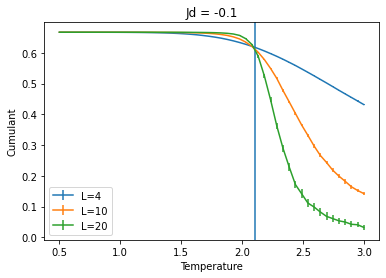

In [10]:
#Jd = -0.1
plt.errorbar(T, binder_4[1, :], err_4[1, :], label = "L=4")#, fmt='o-')
plt.errorbar(T, binder_10[1, :], err_10[1, :], label = "L=10")#, fmt='o-')
plt.errorbar(T, binder_20[1, :], err_20[1, :], label = "L=20")#, fmt='o-')
#plt.errorbar(T, binder_40[1, :], err_40[1, :], label = "L=40", fmt='o-')
#plt.plot(T, binders[0, 4, :], label = "L=80")
plt.xlabel('Temperature')
plt.ylabel('Cumulant')
plt.axvline(x=2.104982167992544)
plt.title("Jd = -0.1")
plt.legend()
plt.show();

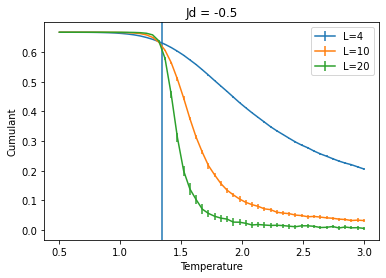

In [11]:
#Jd = -0.5
plt.errorbar(T, binder_4[2, :], err_4[2, :], label = "L=4")#, fmt='o-')
plt.errorbar(T, binder_10[2, :], err_10[2, :], label = "L=10")#, fmt='o-')
plt.errorbar(T, binder_20[2, :], err_20[2, :], label = "L=20")#, fmt='o-')
#plt.errorbar(T, binder_40[2, :], err_40[2, :], label = "L=40", fmt='o-')
#plt.plot(T, binders[0, 4, :], label = "L=80")
plt.axvline(x=1.34187327905057)
plt.xlabel('Temperature')
plt.ylabel('Cumulant')
plt.title("Jd = -0.5")
plt.legend()
plt.show();

In [12]:
# near critical

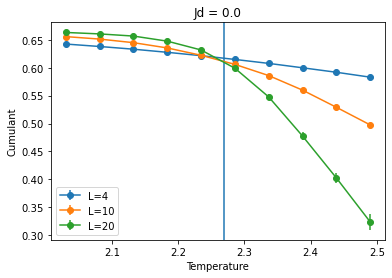

In [16]:
#Jd = 0.0
plt.errorbar(T[30:40], binder_4[0, 30:40], err_4[0, 30:40], label = "L=4", fmt='o-')
plt.errorbar(T[30:40], binder_10[0, 30:40], err_10[0, 30:40], label = "L=10", fmt='o-')
plt.errorbar(T[30:40], binder_20[0, 30:40], err_20[0, 30:40], label = "L=20", fmt='o-')
#plt.errorbar(T, binder_40[0, :], err_40[0, :], label = "L=40", fmt='o-')
#plt.plot(T, binders[0, 4, :], label = "L=80")
plt.xlabel('Temperature')
plt.ylabel('Cumulant')
plt.axvline(x=2.2691853142129728)
plt.title("Jd = 0.0")
plt.legend()
plt.show();

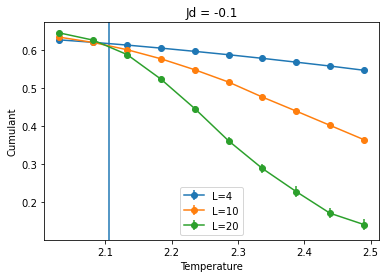

In [17]:
#Jd = -0.1
plt.errorbar(T[30:40], binder_4[1, 30:40], err_4[1, 30:40], label = "L=4", fmt='o-')
plt.errorbar(T[30:40], binder_10[1, 30:40], err_10[1, 30:40], label = "L=10", fmt='o-')
plt.errorbar(T[30:40], binder_20[1, 30:40], err_20[1, 30:40], label = "L=20", fmt='o-')
#plt.errorbar(T, binder_40[1, :], err_40[1, :], label = "L=40", fmt='o-')
#plt.plot(T, binders[0, 4, :], label = "L=80")
plt.xlabel('Temperature')
plt.ylabel('Cumulant')
plt.axvline(x=2.104982167992544)
plt.title("Jd = -0.1")
plt.legend()
plt.show();

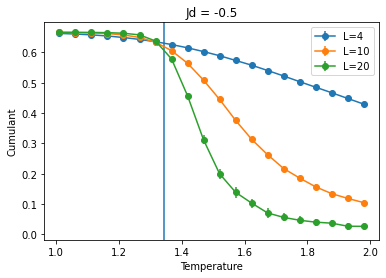

In [20]:
#Jd = -0.5
plt.errorbar(T[10:30], binder_4[2, 10:30], err_4[2, 10:30], label = "L=4", fmt='o-')
plt.errorbar(T[10:30], binder_10[2, 10:30], err_10[2, 10:30], label = "L=10", fmt='o-')
plt.errorbar(T[10:30], binder_20[2, 10:30], err_20[2, 10:30], label = "L=20", fmt='o-')
#plt.errorbar(T, binder_40[2, :], err_40[2, :], label = "L=40", fmt='o-')
#plt.plot(T, binders[0, 4, :], label = "L=80")
plt.axvline(x=1.34187327905057)
plt.xlabel('Temperature')
plt.ylabel('Cumulant')
plt.title("Jd = -0.5")
plt.legend()
plt.show();

In [3]:
import numpy as np
from scipy import optimize

def F(t, Jd):
    return (np.sinh(2/t))**2 + 2 * np.sinh(2/t) * np.sinh(Jd *2/t) - 1

Jd_ar = np.linspace(0, 1., 11, endpoint=True)
print(Jd_ar)
sol=[optimize.root(F,1,Jd).x[0] for Jd in Jd_ar]
sol

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


[2.2691853142129728,
 2.426291319035178,
 2.577356059664392,
 2.7232065461969945,
 2.8645022087095424,
 3.0017774197047054,
 3.1354715107049764,
 3.2659503538230608,
 3.393522159945615,
 3.5184492410503965,
 3.64095690650721]

In [4]:
def F(t):
    Jd = 0.8
    return (np.sinh(2/t))**2 + 2 * np.sinh(2/t) * np.sinh(Jd *2/t) - 1
sol=optimize.root(F,1)
sol

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-8.44562198e-11])
       r: array([0.64883995])
  status: 1
 success: True
       x: array([3.39352216])